### Composites

In this notebook we'll take a closer look at how `pre_et_look` works internally. To do so, we'll be using a couple of functions that you'd normally not need to touch, because they are called automatically when you run `pywapor.pre_et_look.main`.

First, we'll install pywapor in case it's not installed yet.

In [ ]:
!pip install pywapor==2.4.1 --quiet

Then we can define some of the basic parameters, that were explained in the introduction notebook. In this case we'll look at the Fayoum region again, for a period of two months.

In [1]:
import pywapor

project_folder = r"/Users/hmcoerver/pywapor_notebooks"
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]
startdate = "2021-06-01"
enddate = "2021-08-01"

One of the first things happening when you run `pre_et_look`, is the creation of a more precise definition of the composites (from here on also referred to as epochs) for which `pre_et_look` will prepare the data to be used by `et_look`.

The default value for the `composite_length` in `pywapor.pre_et_look.main` is `"DEKAD"`, which creates three composites per month (of roughly 10 days each), just like much of the WaPOR data. We'll go with this default value for now. The variable `epochs_info` consists of three lists, with information on the number, startdate and enddate of each epoch.

In [2]:
composite_length = "DEKAD"

epochs_info = pywapor.pre_et_look.create_dates(startdate, enddate, composite_length)

for number, start, end in zip(*epochs_info):
    print(f"Composite {number + 1} starts at {start} and ends at {end}.\n")

Composite 1 starts at 2021-06-01T00:00:00.000000000 and ends at 2021-06-11T00:00:00.000000000.

Composite 2 starts at 2021-06-11T00:00:00.000000000 and ends at 2021-06-21T00:00:00.000000000.

Composite 3 starts at 2021-06-21T00:00:00.000000000 and ends at 2021-07-01T00:00:00.000000000.

Composite 4 starts at 2021-07-01T00:00:00.000000000 and ends at 2021-07-11T00:00:00.000000000.

Composite 5 starts at 2021-07-11T00:00:00.000000000 and ends at 2021-07-21T00:00:00.000000000.

Composite 6 starts at 2021-07-21T00:00:00.000000000 and ends at 2021-08-01T00:00:00.000000000.



Besides defining the epochs, `pre_et_look` also downloads data. In this example we'll look solely at NDVI data (from MOD13 and MYD13). So let's download some data and store it in our RAW folder. 

With the parameters specified above, we'll need to download five MOD13 and four MYD13 tiles of about 250MB each, so this can take a couple of minutes. If you already did the introduction and your `project_folder` is the same, some of the tiles will already exist and won't be downloaded again.

In [3]:
import os

dl_args = {
            "Dir": os.path.join(project_folder, "RAW"), 
            "latlim": latlim,
            "lonlim": lonlim,
            "Startdate": startdate, 
            "Enddate": enddate,
            }

raw_ndvi_files = pywapor.collect.downloader.collect_sources("ndvi", ["MOD13", "MYD13"], dl_args)

Tile: 5 / 5: 100%|██████████| 258M/258M [05:46<00:00, 743kBytes/s] 
Tile: 4 / 4: 100%|██████████| 244M/244M [02:08<00:00, 1.90MBytes/s]


The variable `raw_ndvi_files` is a list of lists. The first lists contains the paths to MOD13 tiles that were downloaded and the second the paths to the MYD13 files.

In [4]:
print("MOD13 files:")
print(raw_ndvi_files[0])
print("MYD13 files:")
print(raw_ndvi_files[1])

MOD13 files:
['/Users/hmcoerver/pywapor_notebooks/RAW/MODIS/MOD13/NDVI_MOD13Q1_-_16-daily_2021.06.26.tif', '/Users/hmcoerver/pywapor_notebooks/RAW/MODIS/MOD13/NDVI_MOD13Q1_-_16-daily_2021.07.28.tif', '/Users/hmcoerver/pywapor_notebooks/RAW/MODIS/MOD13/NDVI_MOD13Q1_-_16-daily_2021.07.12.tif', '/Users/hmcoerver/pywapor_notebooks/RAW/MODIS/MOD13/NDVI_MOD13Q1_-_16-daily_2021.05.25.tif', '/Users/hmcoerver/pywapor_notebooks/RAW/MODIS/MOD13/NDVI_MOD13Q1_-_16-daily_2021.06.10.tif']
MYD13 files:
['/Users/hmcoerver/pywapor_notebooks/RAW/MODIS/MYD13/NDVI_MYD13Q1_-_16-daily_2021.06.18.tif', '/Users/hmcoerver/pywapor_notebooks/RAW/MODIS/MYD13/NDVI_MYD13Q1_-_16-daily_2021.07.04.tif', '/Users/hmcoerver/pywapor_notebooks/RAW/MODIS/MYD13/NDVI_MYD13Q1_-_16-daily_2021.07.20.tif', '/Users/hmcoerver/pywapor_notebooks/RAW/MODIS/MYD13/NDVI_MYD13Q1_-_16-daily_2021.06.02.tif']


Now that we have defined our epochs and downloaded some data, we can create our first composites using `pywapor.general.compositer.main`. To do so, we need to define one more variable, which specifies what kind of composite we want to create. This variable, cmeta, is a dictionary with a couple of keys.

* `var_name` and `var_unit` simply define the name and unit of the data we are dealing with.
* `spatial_interp` defines the interpolation method used to align datasets with different resolutions with eachother. Since MOD13 and MYD13 each have the same pixel-size, `spatial_interp` is not relevant here. Possible values are "nearest" or "linear".
* Finally, `composite_type` and `temporal_interp` will be explained in more detail below.

> Also note that we're passing `lean_output` as False, by doing so the output of this function will be a bit more extensive than normally, i.e. some temporary internal variables that normally get deleted, are stored and returned now, for the sake of this exercise.

In [5]:
cmeta = {
    "var_name": "ndvi",
    "var_unit": "-",
    "spatial_interp": "nearest",
    "composite_type": "mean",
    "temporal_interp": False,
}

ds = pywapor.general.compositer.main(cmeta, raw_ndvi_files, epochs_info, lean_output = False)

The `compositer.main` function return an xarray.Dataset object. We can inspect it my simple doing the following.

In [6]:
ds

<xarray.Dataset>
Dimensions:         (epoch: 6, time: 9, lat: 408, lon: 510)
Coordinates:
  * epoch           (epoch) int64 0 1 2 3 4 5
  * time            (time) datetime64[ns] 2021-06-02 2021-06-10 ... 2021-08-05
  * lon             (lon) float64 30.2 30.2 30.2 30.21 ... 31.19 31.2 31.2 31.2
  * lat             (lat) float64 29.7 29.7 29.7 29.69 ... 28.91 28.9 28.9 28.9
    epoch_starts    (epoch) datetime64[ns] 2021-06-01 2021-06-11 ... 2021-07-21
    epoch_ends      (epoch) datetime64[ns] 2021-06-11 2021-06-21 ... 2021-08-01
Data variables:
    ndvi            (time, lat, lon) float32 0.1089 0.1065 ... 0.0798 0.0798
    sources         (time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    epochs          (time) float64 0.0 0.0 1.0 2.0 3.0 4.0 4.0 5.0 nan
    ndvi_composite  (epoch, lat, lon) float32 0.1075 0.1055 ... 0.0828 0.0828
Attributes:
    var_name:         ndvi
    var_unit:         -
    spatial_interp:   nearest
    composite_type:   mean
    temporal_interp:  False
    1:                ('*', 'r', 1.0, 'MOD13Q1')
    2:                ('o', 'g', 1.0, 'MYD13Q1')
    0:                ('.', 'k', 0.7, 'Interp.')

You'll see a couple of things here:

* First of all, the dimensions of this dataset.
* Next the different coordinates of the variables.
* Then a list of data variables and their respective dimensions. For example, the variable `ndvi` is a 3-dimensional datacube. This variable contains all the original pixel values from the geoTIFFs we've downloaded earlier. Check that the size of `time` is 9, which equals 5 (MOD13) + 4 (MYD13).
* Finally, there is an attribute section, which stores some metadata on this dataset.

It's quite easy to plot data inside xarray.Dataset object. For example we can create a map of one of the composites we have created (the first epoch in this case).

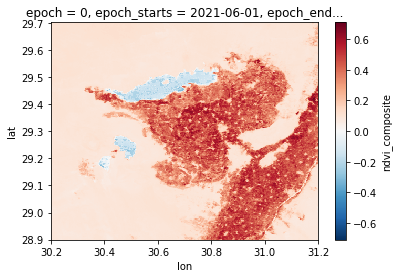

In [7]:
%matplotlib inline
qm = ds.ndvi_composite.isel(epoch = 0).plot()

Next, we can have a closer look at the composites we've created, by defining a dictionary with points-of-interest (POI). Here we'll just add one point to the dictionary and name it "Agriculture", since this point is situated in an agricultural area and we'll also add a dot on the previously created map to see where this point is situated.

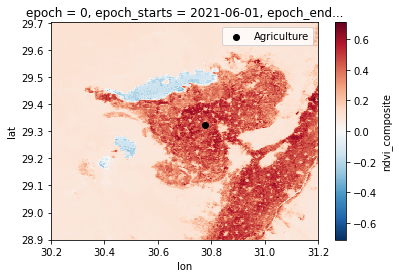

In [8]:
diagnostics = { # label          # lat      # lon
                "Agriculture":	(29.32301,	30.77599),
              }

fig = qm.get_figure()
fig.clf()
qm = ds.ndvi_composite.isel(epoch = 0).plot()
fig = qm.get_figure()
for poi_name, (lat, lon) in diagnostics.items():
    fig.gca().scatter(lon, lat, c = "black", label = poi_name)
fig.gca().legend()

Now we can plot a timeseries of the NDVI at this POI.

>In case you define more POIs, you might also want define an output folder (trough the keyword argument out_folder), as this will make sure the different plots get saved as png-files.

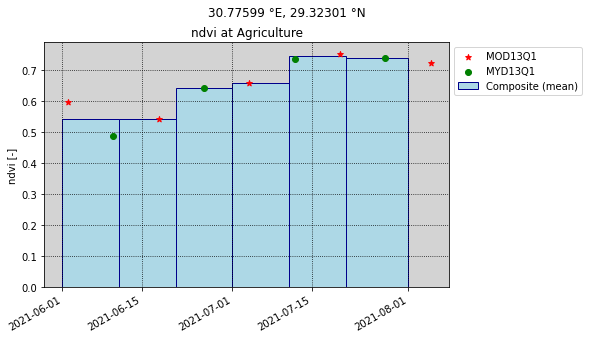

In [9]:
pywapor.post_et_look.plot_composite(ds, diagnostics, band_name = "ndvi")

In the graph we have just created, you should see a couple of things. First of all, there are red-stars and green-dots that show available NDVI measurements at our POI, coming from MOD13 and MYD13 respectively. Then there are blue bars that show the composite pixel values at this location. Since our composites are dekadal, the width of the bars is about 10 days (check the x-axis).

Each composite value is the mean of the available measurements within the respective epoch. For example, most of the bars match with some of the red-stars or green-dots. While the first bar, ranging from June 1st till June 11th is exactly in between two measurements, i.e. it's the mean of the two available measurements.

The composite type is defined using the keyword `composite_type` in the cmeta variable. Possible values are `"mean"`, `"min"`, `"max"` or a float value to calculate a percentile (the percentile option is  significantly more computationally heavy than the others).

Now let's adjust our `composite_length` to create 6-day composites (instead of dekadal) and see what happens.

In [10]:
composite_length = 6

epochs_info = pywapor.pre_et_look.create_dates(startdate, enddate, composite_length)
for number, start, end in zip(*epochs_info):
    print(f"Composite {number + 1} starts at {start} and ends at {end}.\n")

Composite 1 starts at 2021-06-01 00:00:00 and ends at 2021-06-07 00:00:00.

Composite 2 starts at 2021-06-07 00:00:00 and ends at 2021-06-13 00:00:00.

Composite 3 starts at 2021-06-13 00:00:00 and ends at 2021-06-19 00:00:00.

Composite 4 starts at 2021-06-19 00:00:00 and ends at 2021-06-25 00:00:00.

Composite 5 starts at 2021-06-25 00:00:00 and ends at 2021-07-01 00:00:00.

Composite 6 starts at 2021-07-01 00:00:00 and ends at 2021-07-07 00:00:00.

Composite 7 starts at 2021-07-07 00:00:00 and ends at 2021-07-13 00:00:00.

Composite 8 starts at 2021-07-13 00:00:00 and ends at 2021-07-19 00:00:00.

Composite 9 starts at 2021-07-19 00:00:00 and ends at 2021-07-25 00:00:00.

Composite 10 starts at 2021-07-25 00:00:00 and ends at 2021-07-31 00:00:00.

Composite 11 starts at 2021-07-31 00:00:00 and ends at 2021-08-06 00:00:00.



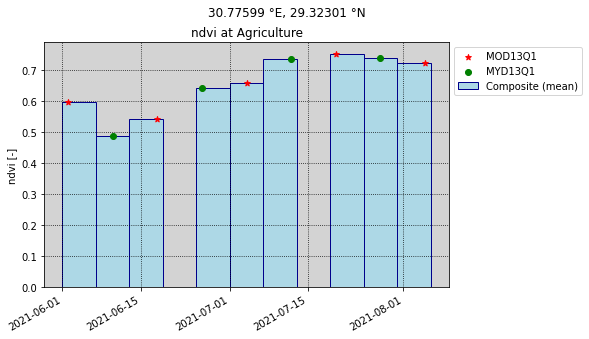

In [11]:
ds = pywapor.general.compositer.main(cmeta, raw_ndvi_files, epochs_info, lean_output = False)
pywapor.post_et_look.plot_composite(ds, diagnostics, band_name = "ndvi")

In the new graph, you'll see that the blue bars have become smaller (i.e. less wide), since our epochs are now shorter. As a result, some composites could not be created, because no NDVI measurements were available during that respective epoch. For example, the fourth composite (ranging between 2021-06-19 00:00:00 and 2021-06-25 00:00:00) is missing.

We solve this by applying a temporal interpolation between the available measurements. This is especially suitable for this data, because the MOD13 and MYD13 datasets itself are 16-daily composites, i.e. their measurements can be considered valid for a 16-day period.

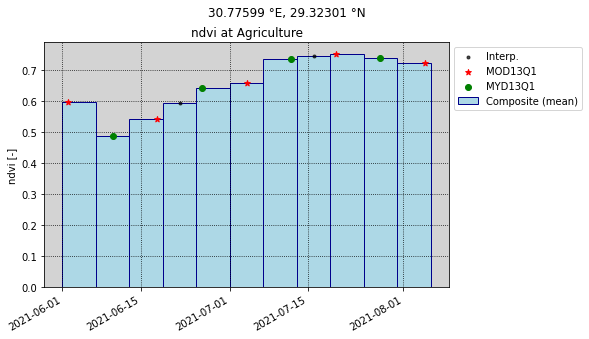

In [12]:
cmeta = {
    "composite_type": "mean",
    "temporal_interp": "linear",
    "spatial_interp": "nearest",
    "var_name": "ndvi",
    "var_unit": "-",
}

ds = pywapor.general.compositer.main(cmeta, raw_ndvi_files, epochs_info, lean_output = False)
pywapor.post_et_look.plot_composite(ds, diagnostics, band_name = "ndvi")

The two composites that were previously missing are now there! You can see that interpolation points (in black) have appeared in the graph. Note that although here we are looking at one pixel, these interpolations are done for the entire domain.

Possible values for temporal_interp are `False`, `"linear"`, `"nearest"`, `"zero"`, `"slinear"`, `"quadratic"` or `"cubic"`. But be aware that some of these can be computationally heavy, as you can see when combining a cubic `temporal_interp` with a percentile `composite_type`.

> ⚠️
>
> This will take some time (and the fans on your computer might start blowing)!
>
> ⚠️

In [ ]:
cmeta = {
    "composite_type": 0.75,
    "temporal_interp": "cubic",
    "spatial_interp": "nearest",
    "var_name": "ndvi",
    "var_unit": "-",
}

ds = pywapor.general.compositer.main(cmeta, raw_ndvi_files, epochs_info, lean_output = False)
pywapor.post_et_look.plot_composite(ds, diagnostics, band_name = "ndvi")